# Abstract

This project introduces an efficient recommendation system that focuses on providing personalized experience and tour suggestions to users. 


The system operates by predicting user preferences based on historical interactions of 139 different users on 16 unique travel experiences, utilizing clustering algorithms to group users with similar tastes, and fine-tuning recommendations for both short experiences and multi-day tours.


This fusion of collaborative and content-based approaches ensures a comprehensive and personalized user experience, aligning recommendations with individual preferences extracted from historical data.

# 1: Imports

Import necessary libraries for data manipulation, machine learning, and natural language processing.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# 2: Load Data

In [2]:
data = pd.read_csv('FINAL_DATA.csv')
tours_data = pd.read_csv('final_tours_and_adventures.csv')

## Analyze Browsing and User Data

In [3]:
data.sample(3)

,experience_id,user,liked,shared,bucketlist,purchased,attended,score,age,avg_accomodation_cost,avg_transport_cost,name,description,adventureLevel,price,gender_Male,featured,rating
157,64fc9b6b3d690a3e195ee90a,7.0,1.0,1.0,1.0,1.0,0.0,4.0,33.0,500.0,1200.0,Trip to Nairobi Snake Park,\nDive into the fascinating world of reptiles ...,6.0,5555.0,0.0,1.0,-0.726114
1870,64fc8bc73d690a3e195ee898,122.0,1.0,1.0,1.0,1.0,1.0,5.0,41.0,1300.0,600.0,Kazuri Beads Factory Tour,"Step into the world of Kazuri Beads Factory, w...",5.2,5555.0,1.0,1.0,-1.538696
1125,64fca0063d690a3e195ee937,74.0,1.0,1.0,0.0,0.0,0.0,2.0,29.0,0.0,0.0,Boat Ride & Crescent Island Walking Safari,Discover the enchanting Crescent Island with a...,6.6,4500.0,1.0,1.0,-0.210802


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2169 entries, 0 to 2168
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   experience_id          2169 non-null   object 
 1   user                   2128 non-null   float64
 2   liked                  2128 non-null   float64
 3   shared                 2128 non-null   float64
 4   bucketlist             2128 non-null   float64
 5   purchased              2128 non-null   float64
 6   attended               2128 non-null   float64
 7   score                  2128 non-null   float64
 8   age                    2128 non-null   float64
 9   avg_accomodation_cost  2128 non-null   float64
 10  avg_transport_cost     2128 non-null   float64
 11  name                   2128 non-null   object 
 12  description            2128 non-null   object 
 13  adventureLevel         2128 non-null   float64
 14  price                  2128 non-null   float64
 15  gend

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user,2128.0,6.871711e+01,41.337419,1.000000,34.000000,69.000000,104.000000,139.00000
liked,2128.0,5.629699e-01,0.496136,0.000000,0.000000,1.000000,1.000000,1.00000
shared,2128.0,4.295113e-01,0.495123,0.000000,0.000000,0.000000,1.000000,1.00000
bucketlist,2128.0,2.922932e-01,0.454923,0.000000,0.000000,0.000000,1.000000,1.00000
purchased,2128.0,2.034774e-01,0.402679,0.000000,0.000000,0.000000,0.000000,1.00000
attended,2128.0,8.223684e-02,0.274790,0.000000,0.000000,0.000000,0.000000,1.00000
score,2128.0,1.572838e+00,1.242317,0.000000,1.000000,1.000000,2.000000,5.00000
age,2128.0,3.352209e+01,7.210743,20.000000,28.000000,31.000000,38.000000,60.00000
avg_accomodation_cost,2128.0,9.398026e+02,1545.553203,0.000000,0.000000,400.000000,1200.000000,8000.00000
avg_transport_cost,2128.0,4.500470e+02,646.012322,0.000000,0.000000,150.000000,700.000000,3000.00000


In [6]:
# Select numerical columns
numerical_columns = ['score', 'age','avg_accomodation_cost', 'avg_transport_cost', 'adventureLevel', 
                     'price', 'rating']

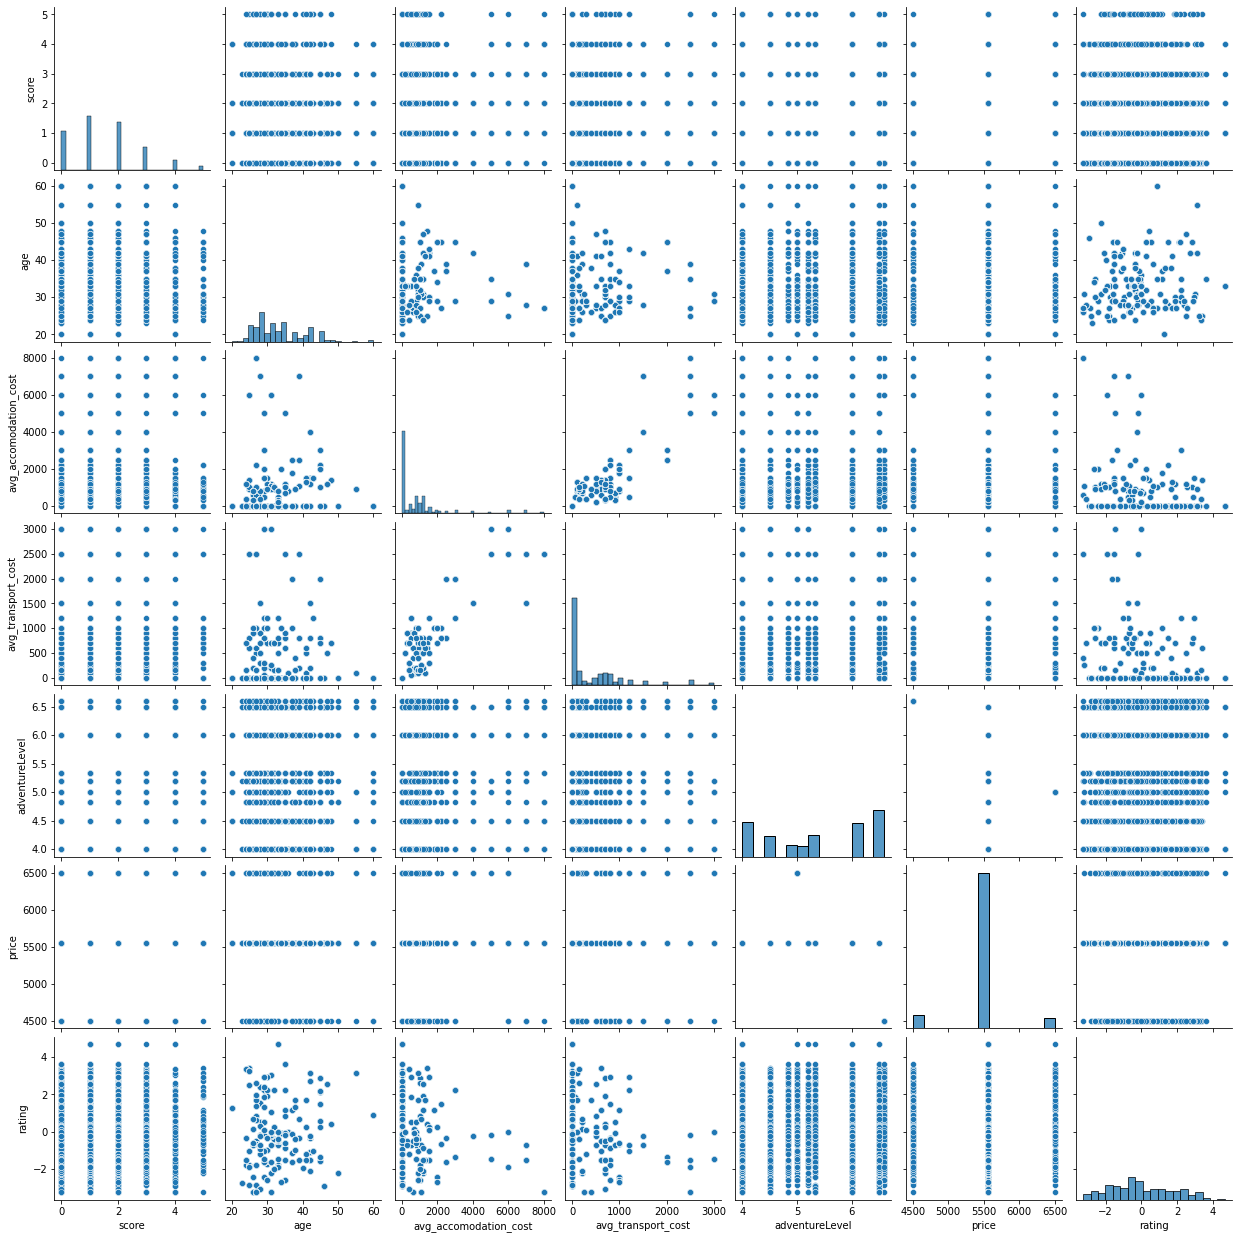

In [7]:
# Pair Plot for Numerical Variables:
sns.pairplot(data[numerical_columns])
plt.show()

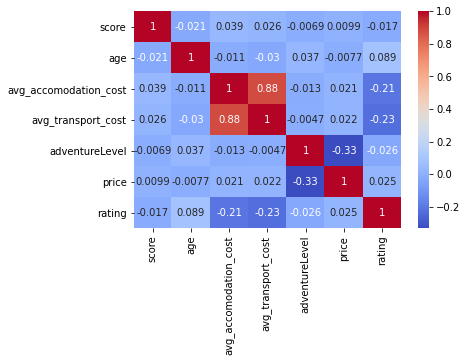

In [8]:
# Correlation Heatmap
correlation_matrix = data[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

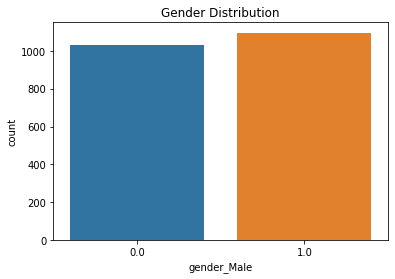

In [9]:
# Gender Distribution
sns.countplot(x='gender_Male', data=data)
plt.title('Gender Distribution')
plt.show()

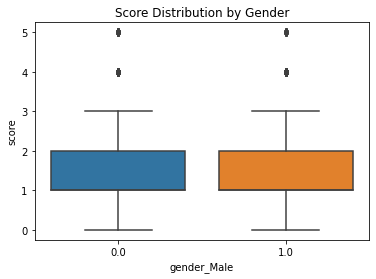

In [10]:
# Box plot for 'score' vs 'gender_Male'
sns.boxplot(x='gender_Male', y='score', data=data)
plt.title('Score Distribution by Gender')
plt.show()

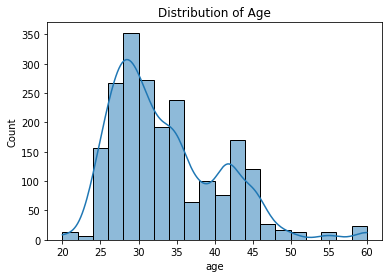

In [11]:
# Distribution plot for 'age'
sns.histplot(data['age'], kde=True, bins=20)
plt.title('Distribution of Age')
plt.show()

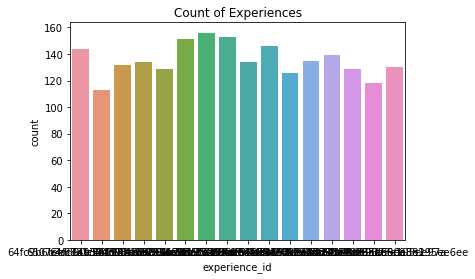

In [12]:
# Bar plot for 'experience_id'
sns.countplot(x='experience_id', data=data)
plt.title('Count of Experiences')
plt.show()

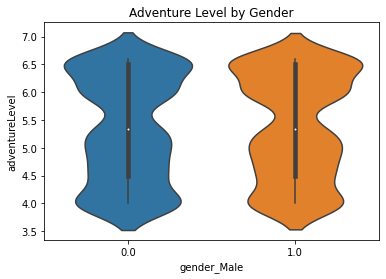

In [13]:
# Violin plot for 'adventureLevel' vs 'gender_Male'
sns.violinplot(x='gender_Male', y='adventureLevel', data=data)
plt.title('Adventure Level by Gender')
plt.show()

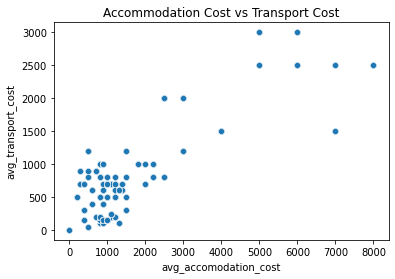

In [14]:
# Scatter plot for 'avg_accomodation_cost' vs 'avg_transport_cost'
sns.scatterplot(x='avg_accomodation_cost', y='avg_transport_cost', data=data)
plt.title('Accommodation Cost vs Transport Cost')
plt.show()

## Analyze Tours Data

In [15]:
tours_data.sample(3)

,name,imageCover,price,description
60,Wonders of Kenya & Tanzania - Mid-Range,https://cloudfront.safaribookings.com/lib/sout...,3450.0,This tour includes 8 days of an authentic expe...
91,Malindi Coastal Exploration,https://yellowzebrasafaris.com/media/46756/aer...,185.0,Embark on a coastal adventure in the beautiful...
36,Safari (Including Masai Mara) & Zanzibar Exten...,https://cloudfront.safaribookings.com/lib/keny...,2250.0,This is a 6-day amazing safari with the best o...


In [16]:
tours_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         103 non-null    object 
 1   imageCover   103 non-null    object 
 2   price        103 non-null    float64
 3   description  103 non-null    object 
dtypes: float64(1), object(3)
memory usage: 3.3+ KB


In [17]:
tours_data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,103.0,1435.368932,2265.03161,115.0,261.0,835.0,1660.0,15160.0


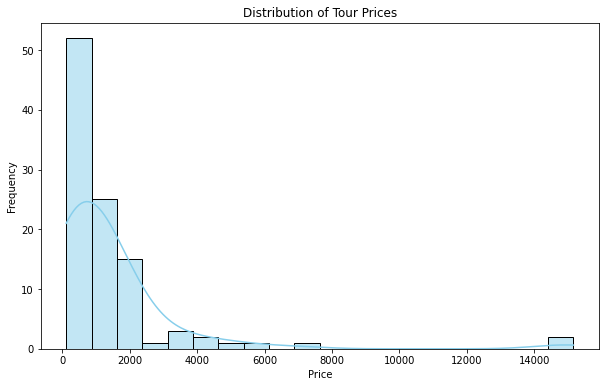

In [18]:
# Histogram for price distribution
plt.figure(figsize=(10, 6))
sns.histplot(tours_data['price'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Tour Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

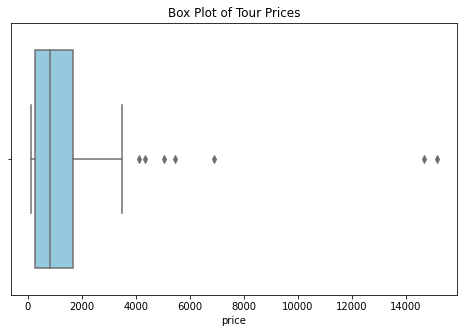

In [19]:
# Box plot for price
plt.figure(figsize=(8, 5))
sns.boxplot(x=tours_data['price'], color='skyblue')
plt.title('Box Plot of Tour Prices')
plt.show()

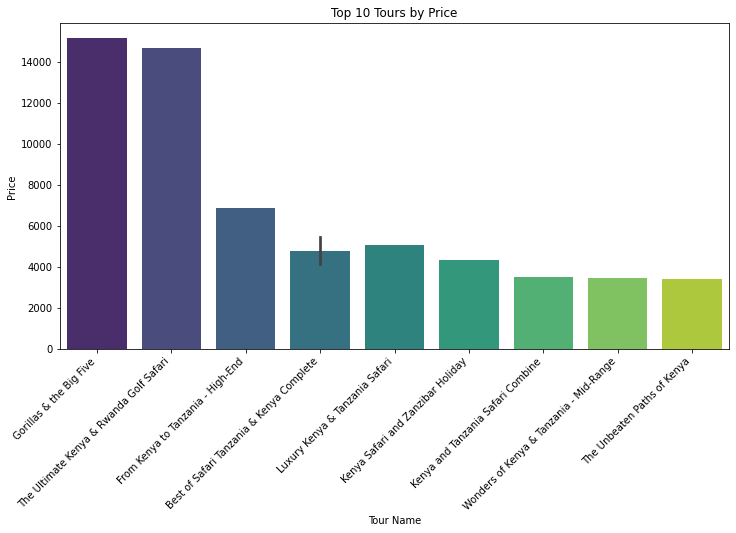

In [20]:
# Bar plot for the top 10 tours based on price
top_10_tours = tours_data.nlargest(10, 'price')
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='price', data=top_10_tours, palette='viridis')
plt.title('Top 10 Tours by Price')
plt.xlabel('Tour Name')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right')
plt.show()

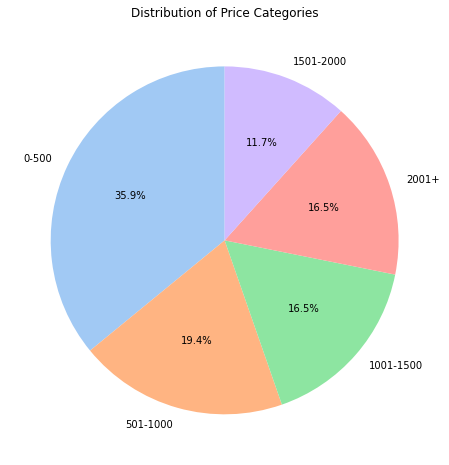

In [21]:
# Create price categories
price_bins = [0, 500, 1000, 1500, 2000, np.inf]
price_labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001+']
tours_data['price_category'] = pd.cut(tours_data['price'], bins=price_bins, labels=price_labels)

# Pie chart for price categories
price_category_counts = tours_data['price_category'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(price_category_counts, labels=price_category_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Distribution of Price Categories')
plt.show()

# 3: Feature Selection

We select relevant features for analysis, focusing on user interactions, tour attributes, and ratings.

In [22]:
selected_features = ['user', 'liked', 'shared', 'bucketlist', 'purchased', 'attended', 'score', 'age', 'avg_accomodation_cost',
                     'avg_transport_cost', 'adventureLevel', 'price', 'gender_Male', 'featured', 'rating']
numerical_data = data[selected_features]

# 4: Correlation Analysis

Explore correlations between selected features to understand relationships within the data.

In [23]:
correlation_matrix = numerical_data.corr()
correlation_matrix

,user,liked,shared,bucketlist,purchased,attended,score,age,avg_accomodation_cost,avg_transport_cost,adventureLevel,price,gender_Male,featured,rating
user,1.000000,-0.019419,0.031690,0.045550,0.015096,0.002711,0.026521,0.045480,0.348113,0.376507,-0.009719,0.017873,-0.035855,0.006630,-0.141861
liked,-0.019419,1.000000,0.048700,0.099637,0.113508,0.049935,0.503237,-0.028578,0.013683,0.004538,-0.015209,-0.010434,-0.051211,0.016357,-0.009264
shared,0.031690,0.048700,1.000000,0.277283,0.125030,0.054721,0.567466,-0.008321,0.030547,0.017869,-0.013709,-0.005771,0.021380,0.008014,-0.026087
bucketlist,0.045550,0.099637,0.277283,1.000000,0.301398,0.191238,0.656101,-0.016731,0.031790,0.023150,0.012155,0.007894,0.007539,0.006886,-0.026488
purchased,0.015096,0.113508,0.125030,0.301398,1.000000,0.571011,0.654072,-0.009563,0.020597,0.023278,0.000217,0.029905,-0.016376,-0.017843,0.000112
attended,0.002711,0.049935,0.054721,0.191238,0.571011,1.000000,0.516113,0.005371,0.005573,0.005672,-0.014783,0.016404,-0.031254,-0.015853,0.009578
score,0.026521,0.503237,0.567466,0.656101,0.654072,0.516113,1.000000,-0.020701,0.038683,0.026357,-0.006858,0.009854,-0.021826,0.000522,-0.016666
age,0.045480,-0.028578,-0.008321,-0.016731,-0.009563,0.005371,-0.020701,1.000000,-0.011492,-0.030067,0.036702,-0.007735,0.411349,-0.012710,0.088797
avg_accomodation_cost,0.348113,0.013683,0.030547,0.031790,0.020597,0.005573,0.038683,-0.011492,1.000000,0.884887,-0.012675,0.021101,-0.054355,-0.005922,-0.205835
avg_transport_cost,0.376507,0.004538,0.017869,0.023150,0.023278,0.005672,0.026357,-0.030067,0.884887,1.000000,-0.004661,0.021708,-0.069883,-0.011281,-0.227383


# 5: Random Forest Regressor

In [24]:
%%time

# Impute missing values
imputer = SimpleImputer()
numerical_data_imputed = pd.DataFrame(imputer.fit_transform(numerical_data), 
                                      columns=numerical_data.columns)

# features  
features = ['liked', 'shared', 'bucketlist', 'purchased', 'attended', 
            'avg_accomodation_cost', 'avg_transport_cost',
            'price', 'featured', 'rating', 'gender_Male', 'price']

# target
target = 'score'

# Split data
X_train, X_test, y_train, y_test = train_test_split(numerical_data_imputed[features], 
                                                    numerical_data_imputed[target],
                                                    test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                               n_iter=10, cv=5, random_state=42, n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = rf_random.best_params_
print("Best Hyperparameters:", best_params)

# Predictions on the test set
y_pred = rf_random.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}
Mean Squared Error (MSE): 0.018529255744559197
Mean Absolute Error (MAE): 0.031305267231575534
R-squared (R2): 0.98837443796891
CPU times: user 484 ms, sys: 139 ms, total: 623 ms
Wall time: 13.8 s


In [25]:
# Add Predicted scores to the dataset
data['predicted_score'] = rf_random.predict(scaler.transform(numerical_data_imputed[
    features]))

# 6: KMeans Clustering

In [26]:
# Pivot table to represent user scores for each experience, filling missing values with 0
user_scored_experiences = data.pivot_table(index='user', columns='experience_id', 
                                           values='predicted_score', fill_value=0)

# Create the user-scored experiences matrix
user_scored_experiences_matrix = user_scored_experiences.values

Best Number of Clusters: 8


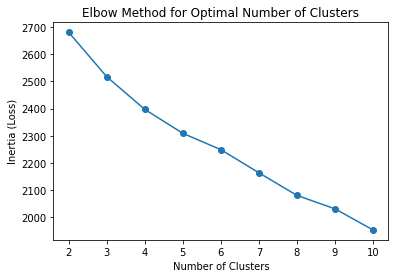

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Create a matrix from the DataFrame
user_scored_experiences_matrix = user_scored_experiences.values

# Set the range of clusters
max_clusters = 10
best_score = -1
best_cluster = 0
loss_values = []

# Iterate over the range of clusters
for n_clusters in range(2, max_clusters + 1):
    
    # Fit KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(user_scored_experiences_matrix)
    
    # Calculate silhouette score
    score = silhouette_score(user_scored_experiences_matrix, cluster_labels)
    
    # Calculate inertia (loss function)
    loss = kmeans.inertia_
    
    # Append loss to the list for later analysis
    loss_values.append(loss)
    
    # Update best cluster if silhouette score is higher
    if score > best_score:
        best_score = score
        best_cluster = n_clusters

# Fit KMeans with the best number of clusters
best_kmeans = KMeans(n_clusters=best_cluster, random_state=42, n_init=10)
user_scored_experiences['cluster'] = best_kmeans.fit_predict(user_scored_experiences_matrix)

# Print the best number of clusters and silhouette score
print(f'Best Number of Clusters: {best_cluster}')

# Plot the loss values against the number of clusters
import matplotlib.pyplot as plt

plt.plot(range(2, max_clusters + 1), loss_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Loss)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

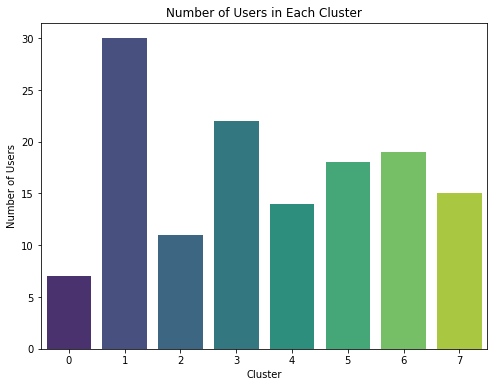

In [28]:
# Count the number of users in each cluster
cluster_counts = user_scored_experiences['cluster'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each Cluster')
plt.show()

# 7: Experience Cross Recommendations Function

Function to provide cross-recommendations for users within the same cluster.

In [29]:
def cross_recommendations(user_id, num_recommendations=5):
    """
    Provide cross-recommendations for a user within the same cluster.

    Parameters:
    - user_id: The user for whom recommendations are generated.
    - num_recommendations: Number of recommendations to provide.

    Returns:
    - List of recommended experience IDs.
    """
    # Get the cluster of the user
    user_cluster = user_scored_experiences.loc[user_id, 'cluster']

    # Filter users within the same cluster
    cluster_users = user_scored_experiences[user_scored_experiences['cluster'] == user_cluster]

    # Get the experiences liked by the user
    user_liked_experiences = user_scored_experiences.loc[user_id, user_scored_experiences.columns[user_scored_experiences.loc[user_id] > 0]].index.tolist()

    # Initialize the list of recommendations
    recommendations = []

    # Iterate over users in the same cluster
    for idx, row in cluster_users.iterrows():
        if idx != user_id:
            # Get liked experiences by the current user in the cluster
            liked_experiences = row[row > 0].index.tolist()

            # Check for new recommendations not liked by the target user
            new_recommendations = set(liked_experiences) - set(user_liked_experiences) - set(recommendations)

            # Add new recommendations to the list
            recommendations.extend(new_recommendations)

            # Break if enough recommendations are found
            if len(recommendations) >= num_recommendations:
                break

    # Return the specified number of recommendations
    return recommendations[:num_recommendations]

In [38]:
user_id_to_recommend = 66 
num_recommendations_to_get = 5
recommended_experiences = cross_recommendations(user_id_to_recommend, num_recommendations_to_get)
recommended_experiences_df = data[data['experience_id'].isin(recommended_experiences)]
recommended_experiences_df[['name', 'description', 'score']].head()

,name,description,score
8,Dive into the Fourteen Falls,Fourteen Falls is nature's masterpiece. Witnes...,1.0
18,Art Viewing at Nairobi Gallery,Journey into the heart of Kenyan art and cultu...,1.0
19,Lunch with Elephants : Sheldrick Wildlife Trust,Embark on a transformative journey at the Shel...,2.0
23,Dive into the Fourteen Falls,Fourteen Falls is nature's masterpiece. Witnes...,2.0
27,Dive into the Fourteen Falls,Fourteen Falls is nature's masterpiece. Witnes...,2.0


# 8: Recommend tours based on a user's preferences using content-based filtering.

This approach recommends tours that align with the textual content of experiences the user has shown interest in, creating a personalized recommendation based on content similarities.


1. Cross-Recommendations for Experiences: We start by obtaining recommendations for experiences using the cross_recommendations function based on the user's preferences or behavior. 


2. Content-Based Filtering for Tours: We use content-based filtering for tours, leveraging natural language processing (NLP) to analyze and compare the textual descriptions of recommended experiences and available tours.


3. Handling NaN Values: We handle potential NaN values in descriptions by replacing them with empty strings for consistency.


4. Vector Representation: We convert tour and experience descriptions into vectors using spaCy's pre-trained word embeddings (Word2Vec).


5. Cosine Similarity: We calculate the cosine similarity between the vectors to measure the similarity between recommended experiences and tours.


6. Scoring and Ranking: We sum the similarity scores for each tour across all recommended experiences and rank tours based on their total similarity scores.


7. Top Recommendations: Finally, we select the top 12 tour recommendations with the highest similarity scores for the user.

In [41]:
from IPython.display import HTML, display

def recommend_tours_based_on_user_preferences(user_id):
    """
    Recommend tours based on a user's preferences using content-based filtering.

    Parameters:
    - user_id: The user for whom tour recommendations are generated.

    Returns:
    - HTML representation of tour recommendations as cards.
    """
    # Cross-Recommendations for Experiences
    recommended_experiences_ids = cross_recommendations(user_id)
    recommended_experiences_df = data[data['experience_id'].isin(recommended_experiences_ids)][['experience_id', 'name', 'description']]

    # Content-Based Filtering for Tours
    nlp = spacy.load("en_core_web_md")

    # Extract descriptions and handle NaN values
    recommended_descriptions = recommended_experiences_df['description'].fillna('').tolist()
    new_tours_descriptions = tours_data['description'].fillna('').tolist()

    # Check if there is data for both recommended experiences and tours
    if not recommended_descriptions or not new_tours_descriptions:
        print("Insufficient data for recommendations.")
        return pd.DataFrame()  # Return an empty DataFrame 

    # Generate vectors for recommended experiences and tours
    recommended_vectors = np.array([nlp(desc).vector for desc in recommended_descriptions])
    new_tours_vectors = np.array([nlp(desc).vector for desc in new_tours_descriptions])

    # Check if vectors are empty
    if not recommended_vectors.size or not new_tours_vectors.size:
        print("Vectors are empty.")
        return pd.DataFrame()  # Return an empty DataFrame

    # Calculate cosine similarity between recommended experiences and tours
    similarity_matrix = cosine_similarity(recommended_vectors, new_tours_vectors)
    total_similarity_scores = similarity_matrix.sum(axis=0)

    # Normalize the similarity scores to be between -1 and 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized_similarity_scores = scaler.fit_transform(total_similarity_scores.reshape(-1, 1))

    # Add normalized similarity scores to tours_data
    tours_data['similarity_score'] = normalized_similarity_scores

    # Sort tours_data by normalized similarity score in descending order
    sorted_tours_data = tours_data.sort_values(by='similarity_score', ascending=False)

    # Select the top 12 tour recommendations
    top_tour_recommendations = sorted_tours_data.head(12)[['imageCover', 'name', 'description', 'price_category', 'similarity_score']]

    # Display the HTML grid with cards
    display_html_grid(top_tour_recommendations)

    return top_tour_recommendations

def display_html_grid(data):
    # Display the recommendations as an HTML grid with cards
    html_content = '<div style="display: flex; flex-wrap: wrap; gap: 20px;">'
    for _, row in data.iterrows():
        # Shorten the description to 18 words max
        shortened_description = ' '.join(row['description'].split()[:18]) + '...' if row['description'] else ''
        html_content += f'''
            <div style="border: 1px solid #ccc; padding: 10px; width: 300px; text-align: center;">
                <img src="{row['imageCover']}" style="max-height: 100px;">
                <p><strong>{row['name']}</strong></p>
                <p>{shortened_description}</p>
                <p>Similarity Score: {row['similarity_score']}</p>
            </div>
        '''
    html_content += '</div>'
    display(HTML(html_content))

In [42]:
%%time

recommend_tours_based_on_user_preferences(66)

CPU times: user 18 s, sys: 1.49 s, total: 19.5 s
Wall time: 20.3 s


,imageCover,name,description,price_category,similarity_score
67,https://cloudfront.safaribookings.com/lib/keny...,"Nairobi Park, Shedrick's Centre and Carnivore",This is a short safari tour of the only park w...,0-500,1.000000
49,https://cloudfront.safaribookings.com/lib/keny...,Lake Naivasha and Masai Mara Safari (Mid-Range),If you are looking for the perfect retreat wit...,501-1000,0.993081
6,https://cloudfront.safaribookings.com/lib/keny...,Great Migration in Masai Mara & Lake Nakuru Sa...,This safari tour is everything that you have w...,501-1000,0.914571
62,https://cloudfront.safaribookings.com/lib/keny...,Maasai Mara and Diani Beach Luxury Safari,This safari gives you the lifetime opportunity...,2001+,0.902527
22,https://cloudfront.safaribookings.com/lib/keny...,"Amboseli NP, Lake Naivasha & Maasai Mara Mid-R...","This Safari will take you to the ""Land of Gian...",1501-2000,0.873120
10,https://cloudfront.safaribookings.com/lib/keny...,High End Luxury Masai Mara & Lake Nakuru Safari,An adventure of its kind that takes you to two...,1501-2000,0.840652
40,https://cloudfront.safaribookings.com/lib/keny...,Amboseli National Park Mid Range Safari Tour,Amboseli National Park is one of the most spec...,501-1000,0.827852
7,https://cloudfront.safaribookings.com/lib/keny...,Luxury Honeymoon Package to the Masai Mara,Spend your honeymoon at the intimate and priva...,501-1000,0.811393
13,https://cloudfront.safaribookings.com/lib/keny...,Wildlife Tour,Discover Kenya in just 5 days. This safari is ...,501-1000,0.797711
72,https://cloudfront.safaribookings.com/lib/keny...,Kenya Safari and Zanzibar Holiday,This luxury holiday offers first-class safari ...,2001+,0.796305


# Conclusion

This recommendation system harmoniously integrates collaborative and content-based filtering methods to cluster users effectively based on predicted preferences, yielding personalized suggestions for both experiences and tours. Leveraging Random Forests for user preference predictions, KMeans clustering for user grouping, and NLP for content-based filtering, the model demonstrates accuracy in delivering tailored recommendations, enhancing user engagement.

The model's accuracy and effectiveness in providing tailored recommendations have been demonstrated, ensuring a more engaging and user-centric experience. The integration of Random Forests allowed for robust prediction of user preferences, KMeans clustering facilitated the identification of user groups with similar tastes, and NLP techniques enhanced the accuracy of tour recommendations.

To further enhance the model, future efforts could focus on optimizing its speed and accuracy. Incorporating more extensive and diverse datasets could contribute to a richer understanding of user preferences. Additionally, exploring advanced NLP techniques and models may further refine content-based recommendations.

Looking forward, this recommendation system presents a valuable tool for Tajriba.app to recommend five experiences per user for each week of the month and twelve tours for each month of the year. This approach not only facilitates a personalized user experience but also allows for systematic monitoring and evaluation based on user engagement and feedback. The continuous feedback loop, driven by newer browsing and booking data, provides a mechanism for iterative improvement and adaptation to evolving user preferences.

Addressing potential challenges, such as optimizing recommendation speed to minimize user wait times, is crucial to prevent user churn. Striking a balance between accuracy and efficiency will be pivotal in maintaining user satisfaction and engagement.